<a href="https://colab.research.google.com/github/likoscp/face_detection/blob/main/Face_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
faces_zip = "/content/drive/MyDrive/face.zip"
robots_zip = "/content/drive/MyDrive/robots.zip"
animal_zip = "/content/drive/MyDrive/animal.zip"
items_zip = "/content/drive/MyDrive/items.zip"
fake_faces_zip = "/content/drive/MyDrive/fake_faces.zip"
anime_faces_zip = "/content/drive/MyDrive/anime_faces.zip"

!mkdir -p /content/dataset/face
!mkdir -p /content/dataset/robots
!mkdir -p /content/dataset/animal
!mkdir -p /content/dataset/items
!mkdir -p /content/dataset/fake_faces
!mkdir -p /content/dataset/anime_faces

!unzip -qo $faces_zip -d /content/dataset/face
!unzip -qo $robots_zip -d /content/dataset/robots
!unzip -qo $animal_zip -d /content/dataset/animal
!unzip -qo $items_zip -d /content/dataset/items
!unzip -qo $fake_faces_zip -d /content/dataset/fake_faces
!unzip -qo $anime_faces_zip -d /content/dataset/anime_faces

In [28]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, datasets
import matplotlib.pyplot as plt
import os, shutil
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
def split_dataset(src_dir, dst_root, class_name, split=(0.7,0.2,0.1)):
    files = os.listdir(src_dir)
    np.random.shuffle(files)

    n_total = len(files)
    n_train = int(split[0] * n_total)
    n_val = int(split[1] * n_total)

    train_files = files[:n_train]
    val_files = files[n_train:n_train+n_val]
    test_files = files[n_train+n_val:]

    for subdir in ["train", "val", "test"]:
        os.makedirs(os.path.join(dst_root, subdir, class_name), exist_ok=True)

    for f in train_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "train", class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "val", class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(src_dir, f), os.path.join(dst_root, "test", class_name, f))

In [30]:
split_dataset("/content/dataset/face", "/content/dataset_ready", "face")
split_dataset("/content/dataset/robots", "/content/dataset_ready", "robots")
split_dataset("/content/dataset/animal", "/content/dataset_ready", "animal")
split_dataset("/content/dataset/items", "/content/dataset_ready", "items")
split_dataset("/content/dataset/fake_faces", "/content/dataset_ready", "fake_faces")
split_dataset("/content/dataset/anime_faces", "/content/dataset_ready", "anime_faces")


In [31]:
# from PIL import Image

# data_dir = "/content/dataset/face"
# max_size = (1280, 1280)

# def resize_big_images(data_dir, max_size=(1280,1280)):
#     for root, dirs, files in os.walk(data_dir):
#         for f in files:
#             path = os.path.join(root, f)
#             try:
#                 img = Image.open(path)
#                 if img.size[0] * img.size[1] > 894788:
#                     print(f"Resizing {path} from {img.size}...")
#                     img.thumbnail(max_size, Image.Resampling.LANCZOS)
#                     img.save(path)
#             except Exception as e:
#                 print(f"Error с {path}: {e}")

# resize_big_images(data_dir, max_size=(1280,1280))


In [32]:
dataset_root = "/content/dataset_ready"
img_size = (128, 128)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = train_datagen.flow_from_directory(
    dataset_root + "/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_directory(
    dataset_root + "/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    dataset_root + "/test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(128, 128, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(train_gen.num_classes, activation="softmax")
])

model_cnn.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])



early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop]
)

test_loss, test_acc = model_cnn.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.4f}")

model_cnn.save("/content/simple_cnn.h5")


Found 695 images belonging to 6 classes.
Found 216 images belonging to 6 classes.
Found 114 images belonging to 6 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 841ms/step - accuracy: 0.2898 - loss: 1.7829 - val_accuracy: 0.5046 - val_loss: 1.4381
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 775ms/step - accuracy: 0.4484 - loss: 1.3373 - val_accuracy: 0.5370 - val_loss: 1.1424
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 775ms/step - accuracy: 0.5066 - loss: 1.1692 - val_accuracy: 0.6296 - val_loss: 0.9968
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 809ms/step - accuracy: 0.5376 - loss: 1.0710 - val_accuracy: 0.6250 - val_loss: 0.9374
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 779ms/step - accuracy: 0.5563 - loss: 0.9969 - val_accuracy: 0.6157 - val_loss: 0.9455
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 826ms/step - accuracy: 0.6383 - loss: 0.9810 - val_accuracy: 0.6204 - val_loss: 0.9138
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 767ms/step - accuracy: 0.6007 - loss: 0.9806 - val_accuracy: 0.6389 - val_loss: 0.8916
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 770ms/step - accuracy: 0.6225 - loss: 0.8885 - val_accu

Test accuracy: 0.6579


In [33]:
# !rm -rf /content/dataset_


In [34]:
import torch
import torchvision
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

COCO_PERSON_LABEL = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
model.to(device)


def predict_image(model, device, image_path, thr=0.5):
    img = Image.open(image_path).convert("RGB")
    transform = T.Compose([T.ToTensor()])
    tensor = transform(img).to(device)

    with torch.no_grad():
        outputs = model([tensor])

    outputs = outputs[0]
    boxes = outputs['boxes'].cpu()
    labels = outputs['labels'].cpu()
    scores = outputs['scores'].cpu()
    person_indices = [i for i, lbl in enumerate(labels) if lbl.item() == COCO_PERSON_LABEL and scores[i].item() >= thr]

    persons = []
    for i in person_indices:
        box = boxes[i].tolist()  # [x1, y1, x2, y2]
        score = float(scores[i].item())
        persons.append({'box': box, 'score': score})

    return img, persons


def draw_boxes(image, persons):
    draw = ImageDraw.Draw(image)
    try:
        font = ImageFont.load_default()
    except Exception:
        font = None

    for p in persons:
        x1, y1, x2, y2 = p['box']
        draw.rectangle([x1, y1, x2, y2], outline="red", width=3)
        label = f"person: {p['score']:.2f}"

        if font:
            bbox = draw.textbbox((x1, y1), label, font=font)
            text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        else:
            text_w, text_h = 50, 10

        draw.rectangle([x1, y1 - text_h, x1 + text_w, y1], fill="red")
        draw.text((x1, y1 - text_h), label, fill="white", font=font)
    return image


def process_image(image_path, thr=0.5):
    img, persons = predict_image(model, device, image_path, thr)
    if persons:
        print(f"Person detected: {len(persons)} (threshold={thr})")
    else:
        print(f"No person detected (threshold={thr})")

    annotated = draw_boxes(img.copy(), persons)
    plt.figure(figsize=(8, 8))
    plt.imshow(annotated)
    plt.axis("off")
    plt.show()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


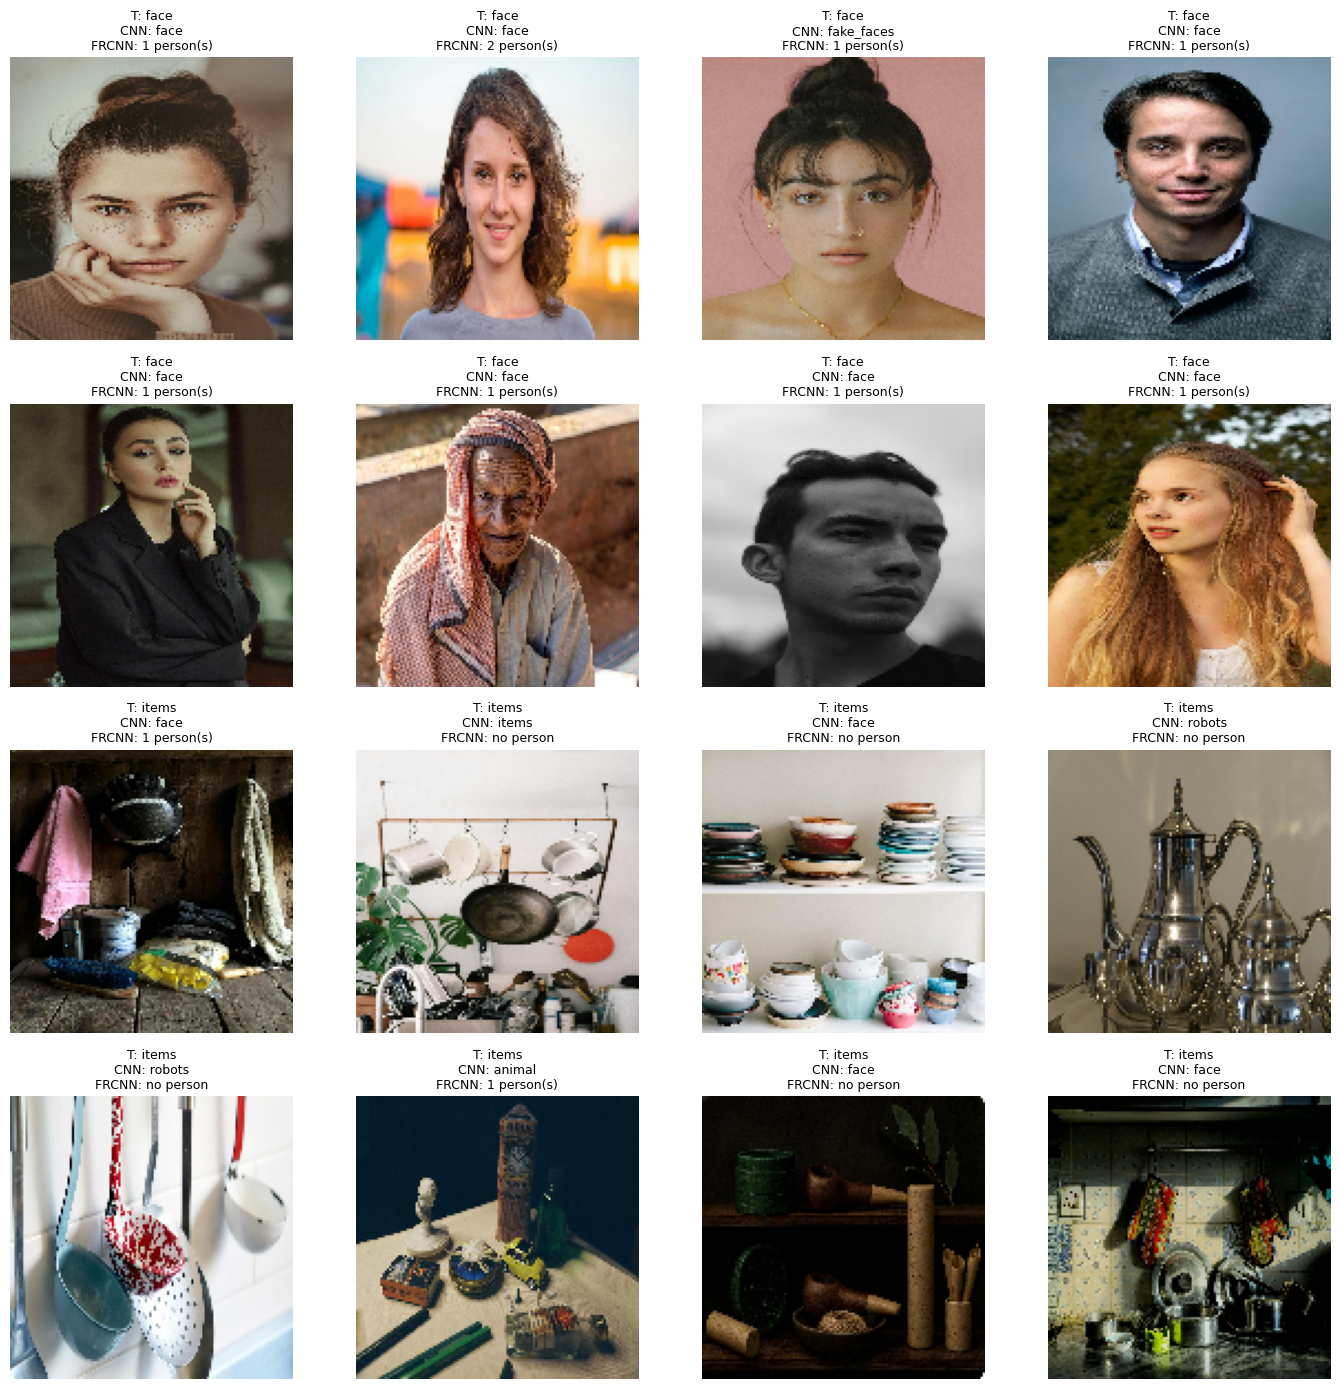

In [42]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class_names = list(train_gen.class_indices.keys())
face_idxs = [class_names.index("face"), class_names.index("fake_faces")]

faces_x, faces_y, other_x, other_y = [], [], [], []

while len(faces_x) < 8 or len(other_x) < 8:
    x_batch, y_batch = next(test_gen)
    y_labels = np.argmax(y_batch, axis=1)
    for i in range(len(x_batch)):
        if y_labels[i] in face_idxs and len(faces_x) < 8:
            faces_x.append(x_batch[i])
            faces_y.append(y_batch[i])
        elif y_labels[i] not in face_idxs and len(other_x) < 8:
            other_x.append(x_batch[i])
            other_y.append(y_batch[i])
        if len(faces_x) >= 8 and len(other_x) >= 8:
            break

x_batch = np.array(faces_x + other_x)
y_batch = np.array(faces_y + other_y)

y_true = np.argmax(y_batch, axis=1)
y_pred = np.argmax(model_cnn.predict(x_batch), axis=1)

plt.figure(figsize=(14, 14))

for i in range(16):
    plt.subplot(4, 4, i+1)
    img_display = (x_batch[i] * 255).astype("uint8")
    plt.imshow(img_display)
    plt.axis("off")

    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]

    tmp_path = "/content/tmp.jpg"
    Image.fromarray(img_display).save(tmp_path)

    _, persons = predict_image(model, device, tmp_path, thr=0.5)
    frcnn_label = f"{len(persons)} person(s)" if persons else "no person"

    plt.title(f"T: {true_label}\nCNN: {pred_label}\nFRCNN: {frcnn_label}",
               fontsize=9)

plt.tight_layout()
plt.show()
